# 0.0 Imports

In [63]:
import warnings
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap
import regex as re
import matplotlib.gridspec as gridspec

from IPython.display     import HTML
from ydata_profiling     import ProfileReport
from pylab               import rcParams
from matplotlib          import pyplot  as plt
from matplotlib import cm
from plotly              import express as px
from sklearn             import cluster as c
from sklearn             import metrics as m
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import ensemble as en
from sklearn             import mixture       as mx
from sklearn.manifold    import TSNE
from scipy.cluster       import hierarchy as hc
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper functions

In [64]:
def jupyter_settings():
    %matplotlib inline
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.set_option('display.expand_frame_repr', False)
    warnings.filterwarnings("ignore")    
    
    sns.set()
    
jupyter_settings()

## 0.2 Load dataset

In [65]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN


In [66]:
# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data description

In [67]:
df1 = df_raw.copy()

## 1.1 Rename columuns

In [68]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data types

In [69]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check NA

In [70]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [71]:
# df1 = df1.dropna(subset=['description', 'customer_id'])

In [72]:
df_missing = df1.loc[df1['customer_id'].isna()]
df_not_missing = df1.loc[~df1['customer_id'].isna()]

# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [73]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.5 Change dtypes

In [74]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [75]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.6 Descriptive statistics

In [76]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical attributes

In [77]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.6.1.1 Quantity

In [78]:
print(len(df1[df1['quantity']==0]))
print(len(df1[df1['quantity']<0]))
print(len(df1[df1['quantity']>0]))

0
10624
531285


#### 1.6.1.2 Unit price

In [79]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.03)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,United Kingdom,15838
108088,C545478,D,Discount,-720,2017-03-01,0.010,United Kingdom,16422
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,United Kingdom,13952
182729,C552569,D,Discount,-240,2017-05-08,0.030,United Kingdom,12901
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,United Kingdom,15618
355050,C567903,M,Manual,-120,2017-09-20,0.030,United Kingdom,16422
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,United Kingdom,16198
361741,568375,BANK CHARGES,Bank Charges,1,2017-09-24,0.001,United Kingdom,13405


In [80]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.04)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,United Kingdom,15838
108088,C545478,D,Discount,-720,2017-03-01,0.010,United Kingdom,16422
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,United Kingdom,13952
182729,C552569,D,Discount,-240,2017-05-08,0.030,United Kingdom,12901
217060,555876,16045,POPART WOODEN PENCILS ASST,100,2017-06-05,0.040,United Kingdom,15799
...,...,...,...,...,...,...,...,...
492556,578126,16045,POPART WOODEN PENCILS ASST,100,2017-11-21,0.040,United Kingdom,16900
506043,579124,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,United Kingdom,15721
506918,579161,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,United Kingdom,17379
523461,580513,16045,POPART WOODEN PENCILS ASST,100,2017-12-02,0.040,United Kingdom,14456


In [81]:
len(df1[df1['unit_price']<0.05])

2591

#### 1.6.1.3 Customer id

In [82]:
len(df1['customer_id'].unique())

8082

questions :

Negativate quantity - product return?

Unit price 0 - promotion/sale?

### 1.6.2 Categorical attributes

#### 1.6.2.1 Invoice no

In [83]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]
# df_letter_invoices.head()

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity in invoices with letters: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))
print('% of the total data: {:.2f}%'.format((df_letter_invoices.shape[0] / df1.shape[0])*100))

Total number of invoices with letters: 9291
Total number of negative quantity in invoices with letters: 9288
% of the total data: 1.71%


In [84]:
df_letter_invoices[df_letter_invoices['quantity'] > 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


remove customers 21497,21498,21499

#### 1.6.2.2 Stock code

In [85]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [86]:
df_stock_letters=df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code']
print('% of the total data: {:.2f}%'.format((df_stock_letters.shape[0] / df1.shape[0])*100))

% of the total data: 0.51%


In [87]:
df1[df1['stock_code']=='POST'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.0,France,12583
386,536403,POST,POSTAGE,1,2016-11-29,15.0,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.0,Germany,12662
5073,536840,POST,POSTAGE,1,2016-11-30,18.0,Germany,12738
5258,536852,POST,POSTAGE,1,2016-12-01,18.0,France,12686


In [88]:
df1[df1['stock_code']=='D']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
9038,C537164,D,Discount,-1,2016-12-03,29.29,United Kingdom,14527
14498,C537597,D,Discount,-1,2016-12-05,281.00,United Kingdom,15498
19392,C537857,D,Discount,-1,2016-12-06,267.12,United Kingdom,17340
31134,C538897,D,Discount,-1,2016-12-13,5.76,United Kingdom,16422
...,...,...,...,...,...,...,...,...
479868,C577227,D,Discount,-1,2017-11-16,19.82,United Kingdom,14527
479869,C577227,D,Discount,-1,2017-11-16,16.76,United Kingdom,14527
493613,C578239,D,Discount,-1,2017-11-21,26.33,Italy,14912
516221,C579884,D,Discount,-1,2017-11-28,20.53,United Kingdom,14527


In [89]:
df1[(df1['stock_code']=='D') & (df1['quantity']>0)]

# will be removed with invoice letters

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id


In [90]:
df1[df1['stock_code']=='DOT']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001
3041,536592,DOT,DOTCOM POSTAGE,1,2016-11-29,607.49,United Kingdom,19014
5450,536862,DOT,DOTCOM POSTAGE,1,2016-12-01,254.43,United Kingdom,19023
5545,536864,DOT,DOTCOM POSTAGE,1,2016-12-01,121.06,United Kingdom,19024
5685,536865,DOT,DOTCOM POSTAGE,1,2016-12-01,498.47,United Kingdom,19025
...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2017-12-06,1008.96,United Kingdom,22696
537254,581238,DOT,DOTCOM POSTAGE,1,2017-12-06,1683.75,United Kingdom,22699
539368,581439,DOT,DOTCOM POSTAGE,1,2017-12-06,938.59,United Kingdom,22706
540908,581492,DOT,DOTCOM POSTAGE,1,2017-12-07,933.17,United Kingdom,22707


In [91]:
df1[df1['stock_code']=='M']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
2239,536569,M,Manual,1,2016-11-29,1.25,United Kingdom,16274
2250,536569,M,Manual,1,2016-11-29,18.95,United Kingdom,16274
5684,536865,M,Manual,1,2016-12-01,2.55,United Kingdom,19025
6798,536981,M,Manual,2,2016-12-01,0.85,United Kingdom,14723
7976,537077,M,Manual,12,2016-12-03,0.42,United Kingdom,17062
...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2017-12-04,1.25,United Kingdom,17841
533082,C581009,M,Manual,-1,2017-12-05,125.00,United Kingdom,16971
534308,C581145,M,Manual,-1,2017-12-05,9.95,United Kingdom,17490
538321,581405,M,Manual,3,2017-12-06,0.42,United Kingdom,13521


In [92]:
df1[df1['stock_code']=='S']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
14436,C537581,S,SAMPLES,-1,2016-12-05,12.95,United Kingdom,19100
14437,C537581,S,SAMPLES,-1,2016-12-05,52.00,United Kingdom,19100
96680,C544580,S,SAMPLES,-1,2017-02-19,5.74,United Kingdom,19707
96681,C544580,S,SAMPLES,-1,2017-02-19,11.08,United Kingdom,19707
96682,C544580,S,SAMPLES,-1,2017-02-19,5.79,United Kingdom,19707
...,...,...,...,...,...,...,...,...
414147,C572347,S,SAMPLES,-1,2017-10-22,33.05,United Kingdom,22090
419666,572849,S,SAMPLES,1,2017-10-24,33.05,United Kingdom,22159
480961,C577330,S,SAMPLES,-1,2017-11-16,2.89,United Kingdom,22469
480962,C577330,S,SAMPLES,-1,2017-11-16,75.00,United Kingdom,22469


In [93]:
df1[(df1['stock_code']=='S') & (df1['quantity']>0)]

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
152709,549684,S,SAMPLES,1,2017-04-09,30.00,United Kingdom,20307
419666,572849,S,SAMPLES,1,2017-10-24,33.05,United Kingdom,22159


In [94]:
df1[df1['stock_code']=='AMAZONFEE'].head()

# remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2016-12-05,1.00,United Kingdom,19101
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13541.33,United Kingdom,19105
15017,537632,AMAZONFEE,AMAZON FEE,1,2016-12-05,13541.33,United Kingdom,19106
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13474.79,United Kingdom,19116
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2016-12-05,5519.25,United Kingdom,19117


In [95]:
df1[df1['stock_code']=='m']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
40383,539736,m,Manual,1,2016-12-19,2.55,United Kingdom,19282


In [96]:
df1[df1['stock_code']=='DCGSSBOY'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
84016,543358,DCGSSBOY,BOYS PARTY BAG,1,2017-02-05,3.29,United Kingdom,19614
97246,544599,DCGSSBOY,BOYS PARTY BAG,1,2017-02-19,3.29,United Kingdom,19715
112723,545897,DCGSSBOY,BOYS PARTY BAG,5,2017-03-05,3.29,United Kingdom,19801
116891,546306,DCGSSBOY,BOYS PARTY BAG,1,2017-03-08,3.29,United Kingdom,19843
128107,547249,DCGSSBOY,BOYS PARTY BAG,6,2017-03-20,3.29,United Kingdom,19916


In [97]:
df1[df1['stock_code']=='DCGSSGIRL'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
84017,543358,DCGSSGIRL,GIRLS PARTY BAG,3,2017-02-05,3.29,United Kingdom,19614
112724,545897,DCGSSGIRL,GIRLS PARTY BAG,5,2017-03-05,3.29,United Kingdom,19801
116892,546306,DCGSSGIRL,GIRLS PARTY BAG,2,2017-03-08,3.29,United Kingdom,19843
128108,547249,DCGSSGIRL,GIRLS PARTY BAG,17,2017-03-20,3.29,United Kingdom,19916
128269,547250,DCGSSGIRL,GIRLS PARTY BAG,2,2017-03-20,3.29,United Kingdom,19917


In [98]:
# df1[df1['stock_code']=='PADS'].head()

# removed with low price

In [99]:
df1[df1['stock_code']=='B']

# remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


In [100]:
# df1[df1['stock_code']=='CRUK'].head()

# will be removed with invoice letters

TO REMOVE: 'AMAZONFEE', 'B'

#### 1.6.2.3 Description

In [101]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### 1.6.2.4 Country

In [102]:
df1['country'].value_counts(normalize=True).head()

country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

In [103]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0 Variable filtering 

In [104]:
df2 = df1.copy()

In [105]:
# unit price
df2 = df2.loc[df2['unit_price'] >= 0.04]

# stock code
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop(columns='description', axis=1)

df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2=df2[~df2['customer_id'].isin([12346,16446,21497,21498,21499])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0]

# purchases
df2_purchases = df2.loc[df1['quantity'] >= 0]


print('% of the data lost : {:.3f}%'.format(1-(df2.shape[0] / df1.shape[0])))

% of the data lost : 0.011%


# 3.0 Feature engineering 

In [106]:
df3 = df2.copy()

## 3.1 Feature creation

In [107]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross revenue

In [108]:
# quantity * price
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Average ticket value 

In [109]:
# average gross revenue
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
dtype: int64

### 3.1.2 Recency

In [110]:
# how many days since last purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
recency_days     91
dtype: int64

### 3.1.3 Frequency 

In [111]:
# frequency of purchases
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_ = ('invoice_date', 'max'), 
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_= ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                   buy_ = ('invoice_no', 'count'))).reset_index()
# # Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1)

# # Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
recency_days     91
frequency        91
dtype: int64

### 3.1.4 Total invoices

In [112]:
# total of invoices
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .count()
                                                             .reset_index()
                                                             .rename(columns={'invoice_no': 'total_invoices'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
avg_ticket        91
recency_days      91
frequency         91
total_invoices    91
dtype: int64

### 3.1.5 Total of items purchased 

In [113]:
# number of products purchases
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum()
                                                           .reset_index()
                                                           .rename(columns={'quantity': 'items_qtt'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
avg_ticket        91
recency_days      91
frequency         91
total_invoices    91
items_qtt         91
dtype: int64

### 3.1.6 Total of different items purchased 

In [114]:
# number of different items purchased
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count()
                                                           .reset_index()
                                                           .rename(columns={'stock_code': 'products_qtt'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
avg_ticket        91
recency_days      91
frequency         91
total_invoices    91
items_qtt         91
products_qtt      91
dtype: int64

### 3.1.9 Basket size 

In [115]:
# quantity of items per invoice
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                            .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                  n_products=('quantity', 'sum'))
                                                                            .reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id         0
gross_revenue      91
avg_ticket         91
recency_days       91
frequency          91
total_invoices     91
items_qtt          91
products_qtt       91
avg_basket_size    91
dtype: int64

### 3.2.0 Unique basket size 

In [116]:
# quantity of different items per invoice
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                            .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                   n_products=('stock_code', 'nunique'))
                                                                            .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                0
gross_revenue             91
avg_ticket                91
recency_days              91
frequency                 91
total_invoices            91
items_qtt                 91
products_qtt              91
avg_basket_size           91
avg_unique_basket_size    91
dtype: int64

### 3.1.7 Returns 

In [117]:
# total number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'returns_qtt'})
df_returns['returns_qtt'] = df_returns['returns_qtt'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['returns_qtt'].isna(), 'returns_qtt'] = 0

df_ref.isna().sum()

customer_id                0
gross_revenue             91
avg_ticket                91
recency_days              91
frequency                 91
total_invoices            91
items_qtt                 91
products_qtt              91
avg_basket_size           91
avg_unique_basket_size    91
returns_qtt                0
dtype: int64

In [118]:
df_ref = df_ref.dropna()
df_ref.isna().sum()

customer_id               0
gross_revenue             0
avg_ticket                0
recency_days              0
frequency                 0
total_invoices            0
items_qtt                 0
products_qtt              0
avg_basket_size           0
avg_unique_basket_size    0
returns_qtt               0
dtype: int64

# 4.0 <s>EDA (Exploratory Data Analysis)<s/> 

In [119]:
df4 = df_ref.copy()

In [120]:
# profile = ProfileReport(df4)
# profile.to_file('../img/output_v1.html')

## 4.1 Univariate analysis

## 4.2 Bivariate analysis

In [121]:
# sns.pairplot(df42);

## 4.3 Embedding spaces

### 4.3.1 Transformations

In [122]:
# X1 = df4.drop(columns=['customer_id','avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1).copy()

# ssgross = pp.RobustScaler()
# ssrecency = pp.RobustScaler()
# ssfrequency = pp.RobustScaler()
# ssinvoices = pp.RobustScaler()
# ssitems = pp.RobustScaler()
# ssproducts = pp.RobustScaler()
# ssreturns = pp.RobustScaler()

# X1['gross_revenue'] = ssgross.fit_transform(X1[['gross_revenue']])
# X1['frequency'] = ssfrequency.fit_transform(X1[['frequency']])
# X1['total_invoices'] = ssinvoices.fit_transform(X1[['total_invoices']])
# X1['items_qtt'] = ssitems.fit_transform(X1[['items_qtt']])
# X1['products_qtt'] = ssproducts.fit_transform(X1[['products_qtt']])
# X1['returns_qtt'] = ssreturns.fit_transform(X1[['returns_qtt']])

# X2 = df4.drop(columns=['customer_id','avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1).copy()

# ssgross = pp.MinMaxScaler()
# ssrecency = pp.MinMaxScaler()
# ssfrequency = pp.MinMaxScaler()
# ssinvoices = pp.MinMaxScaler()
# ssitems = pp.MinMaxScaler()
# ssproducts = pp.MinMaxScaler()
# ssreturns = pp.MinMaxScaler()

# X2['gross_revenue'] = ssgross.fit_transform(X2[['gross_revenue']])
# X2['recency_days'] = ssrecency.fit_transform(X2[['recency_days']])
# X2['frequency'] = ssfrequency.fit_transform(X2[['frequency']])
# X2['total_invoices'] = ssinvoices.fit_transform(X2[['total_invoices']])
# X2['items_qtt'] = ssitems.fit_transform(X2[['items_qtt']])
# X2['products_qtt'] = ssproducts.fit_transform(X2[['products_qtt']])
# X2['returns_qtt'] = ssreturns.fit_transform(X2[['returns_qtt']])

# X3 = df4.drop(columns=['customer_id','avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1).copy()

# ssgross = pp.StandardScaler()
# ssrecency = pp.StandardScaler()
# ssfrequency = pp.StandardScaler()
# ssinvoices = pp.StandardScaler()
# ssitems = pp.StandardScaler()
# ssproducts = pp.StandardScaler()
# ssreturns = pp.StandardScaler()

# X3['gross_revenue'] = ssgross.fit_transform(X3[['gross_revenue']])
# X3['recency_days'] = ssrecency.fit_transform(X3[['recency_days']])
# X3['frequency'] = ssfrequency.fit_transform(X3[['frequency']])
# X3['total_invoices'] = ssinvoices.fit_transform(X3[['total_invoices']])
# X3['items_qtt'] = ssitems.fit_transform(X3[['items_qtt']])
# X3['products_qtt'] = ssproducts.fit_transform(X3[['products_qtt']])
# X3['returns_qtt'] = ssreturns.fit_transform(X3[['returns_qtt']])

### 4.3.2 PCA, UMAP, t-SNE and Tree-based embeddings

In [123]:
# # PCA=========================================================

# rcParams['figure.figsize'] = 20,20
# grid=gridspec.GridSpec(4,3)

# # robust scaler
# pca = dd.PCA(n_components=X1.shape[1])

# principal_components = pca.fit_transform(X1)

# # plot explained variable
# features = range(pca.n_components_)

# # ax1 = plt.subplot(grid[0,0]) 
# # plt.bar(features, pca.explained_variance_ratio_, color='black')

# # pca component
# df_pca = pd.DataFrame(principal_components)

# ax1 = plt.subplot(grid[0,0]) 
# sns.scatterplot(x=0, y=1, data=df_pca);


# # min max scaler
# pca = dd.PCA(n_components=X2.shape[1])

# principal_components = pca.fit_transform(X2)

# # plot explained variable
# features = range(pca.n_components_)

# # a3 = plt.subplot(grid[1,0]) 
# # plt.bar(features, pca.explained_variance_ratio_, color='black')

# # pca component
# df_pca = pd.DataFrame(principal_components)

# ax2 = plt.subplot(grid[0,1])
# sns.scatterplot(x=0, y=1, data=df_pca);


# # normalization
# pca = dd.PCA(n_components=X3.shape[1])

# principal_components = pca.fit_transform(X3)

# # plot explained variable
# features = range(pca.n_components_)

# # ax5 = plt.subplot(grid[2,0]) 
# # plt.bar(features, pca.explained_variance_ratio_, color='black')

# # pca component
# df_pca = pd.DataFrame(principal_components)

# ax3 = plt.subplot(grid[0,2]) 
# sns.scatterplot(x=0, y=1, data=df_pca);

# ax1.legend(title='PCA-Robust scaler', fontsize="x-large");
# ax2.legend(title='PCA-Min Max scaler', fontsize="x-large");
# ax3.legend(title='PCA-Normalization', fontsize="x-large");


# # UMAP===========================================================================
# # reducer
# reducer = umap.UMAP(random_state=42)

# # robust scaler
# embedding = reducer.fit_transform(X1)

# # embedding
# df_umap_rs = pd.DataFrame()
# df_umap_rs['embedding_x'] = embedding[:, 0]
# df_umap_rs['embedding_y'] = embedding[:, 1]

# # plot UMAP
# ax4 = plt.subplot(grid[1,0]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_umap_rs);


# # min max scaler
# embedding = reducer.fit_transform(X2)

# # embedding
# df_umap_mms = pd.DataFrame()
# df_umap_mms['embedding_x'] = embedding[:, 0]
# df_umap_mms['embedding_y'] = embedding[:, 1]

# # plot UMAP
# ax5 = plt.subplot(grid[1,1]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_umap_mms);


# # normalization
# embedding = reducer.fit_transform(X3)

# # embedding
# df_umap_nor = pd.DataFrame()
# df_umap_nor['embedding_x'] = embedding[:, 0]
# df_umap_nor['embedding_y'] = embedding[:, 1]

# # plot UMAP
# ax6 = plt.subplot(grid[1,2]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_umap_nor);

# ax4.legend(title='UMAP-Robust scaler', fontsize="x-large");
# ax5.legend(title='UMAP-Min Max scaler', fontsize="x-large");
# ax6.legend(title='UMAP-Normalization', fontsize="x-large");


# # TSNE===========================================================================
# # reducer
# reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)

# # robust scaler
# embedding = reducer.fit_transform(X1)

# # embedding
# df_tsne_rs = pd.DataFrame()
# df_tsne_rs['embedding_x'] = embedding[:, 0]
# df_tsne_rs['embedding_y'] = embedding[:, 1]

# # plot tsne
# ax7 = plt.subplot(grid[2,0]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tsne_rs);


# # min max scaler
# embedding = reducer.fit_transform(X2)

# # embedding
# df_tsne_mms = pd.DataFrame()
# df_tsne_mms['embedding_x'] = embedding[:, 0]
# df_tsne_mms['embedding_y'] = embedding[:, 1]

# # plot tsne
# ax8 = plt.subplot(grid[2,1]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tsne_mms);


# # normalization
# embedding = reducer.fit_transform(X3)

# # embedding
# df_tsne_nor = pd.DataFrame()
# df_tsne_nor['embedding_x'] = embedding[:, 0]
# df_tsne_nor['embedding_y'] = embedding[:, 1]

# # plot plot tsne
# ax9 = plt.subplot(grid[2,2]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tsne_nor);

# ax7.legend(title='tSNE-Robust scaler', fontsize="x-large");
# ax8.legend(title='tSNE-Min Max scaler', fontsize="x-large");
# ax9.legend(title='tSNE-Normalization', fontsize="x-large");


# # TREE==================================================
# # training dataset
# X1 = df4.drop(columns=['customer_id','gross_revenue','avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1).copy()
# y = df4['gross_revenue']


# # model definition
# rf_model = en.RandomForestRegressor( random_state=42)

# # model training
# rf_model.fit(X1, y)

# # leaf
# df_leaf = pd.DataFrame(rf_model.apply(X1))

# # PCA TREE
# pca = dd.PCA(X1.shape[1])

# principal_components = pca.fit_transform(df_leaf)

# # plot explained variable
# features = range(pca.n_components_)

# # ax1 = plt.subplot(grid[0,0]) 
# # plt.bar(features, pca.explained_variance_ratio_, color='black')

# # pca component
# df_pca = pd.DataFrame(principal_components)

# ax10 = plt.subplot(grid[3,0]) 
# sns.scatterplot(x=0, y=1, data=df_pca);
# ax10.legend(title='Tree based PCA', fontsize="x-large");


# # UMAP TREE
# reducer = umap.UMAP(random_state=42)
# embedding = reducer.fit_transform(df_leaf)

# # embedding
# df_umap_tree = pd.DataFrame()
# df_umap_tree['embedding_x'] = embedding[:, 0]
# df_umap_tree['embedding_y'] = embedding[:, 1]

# # plot UMAP
# aX1 = plt.subplot(grid[3,1]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_umap_tree);

# aX1.legend(title='Tree based UMAP', fontsize="x-large");


# # TSNE
# reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
# embedding = reducer.fit_transform(df_leaf)

# # embedding
# df_tsne_tree = pd.DataFrame()
# df_tsne_tree['embedding_x'] = embedding[:, 0]
# df_tsne_tree['embedding_y'] = embedding[:, 1]

# # plot tsne
# aX2 = plt.subplot(grid[3,2]) 
# sns.scatterplot(x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tsne_tree);

# aX2.legend(title='Tree based TSNE', fontsize="x-large");

# 5.0 Data preparation 

In [124]:
df5 = df4.copy()
df5=df5.drop(columns=['avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1)

# <s>6.0 Feature selection</s> 

In [125]:
df6 = df5.copy()

## 6.1 Random forest regressor 

In [126]:
# rcParams['figure.figsize'] = 10,5

# # model definition
# forest=en.RandomForestRegressor(random_state=42,n_jobs=-1) 

# # data preparation
# x_train_n=df6.drop(['gross_revenue'],axis=1)
# y_train=df6['gross_revenue']
# y_train_n=y_train.values
# forest.fit(x_train_n,y_train_n)

# importances=forest.feature_importances_
# std=np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
# indices=np.argsort(importances)[::-1]  

# # print the feature ranking
# print('Feature ranking')
# df=pd.DataFrame()
# for i, j in zip(x_train_n,forest.feature_importances_): 
#     aux=pd.DataFrame({'feature':i,'importance':j},index=[0])
#     df=pd.concat([df,aux],axis=0)
    
# print(df.sort_values('importance',ascending=False))

# # plot the imputiry-based feature importances of the forest
# plt.figure()
# plt.title('feature importances')
# plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
# plt.xticks(range(x_train_n.shape[1]),indices)
# plt.xlim([-1,x_train_n.shape[1]])
# plt.show()

# 7.0 Hyperparameter Fine-Tunning

In [127]:
df7=df6.copy()

## 7.1 UMAP n-components

### 7.1.1 2 to 10 n-components

In [128]:
# TREE==================================================
# training dataset
X1 = df7.drop(columns=['customer_id','gross_revenue'], axis=1)
y = df7['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(random_state=42)

# model training
rf_model.fit(X1, y)

# leaf
df_leaf = pd.DataFrame(rf_model.apply(X1))

# UMAP TREE 1
reducer = umap.UMAP(n_components=2,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df11 = pd.DataFrame()
df11['embedding_x'] = embedding[:, 0]
df11['embedding_y'] = embedding[:, 1]

# UMAP TREE 2
reducer = umap.UMAP(n_components=3,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df22 = pd.DataFrame()
df22['embedding_x'] = embedding[:, 0]
df22['embedding_y'] = embedding[:, 1]
df22['embedding_z'] = embedding[:, 2]

# UMAP TREE 3
reducer = umap.UMAP(n_components=4,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df33 = pd.DataFrame()
df33['embedding_x'] = embedding[:, 0]
df33['embedding_y'] = embedding[:, 1]
df33['embedding_z'] = embedding[:, 2]
df33['embedding_a'] = embedding[:, 3]

# UMAP TREE 4
reducer = umap.UMAP(n_components=5,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df44 = pd.DataFrame()
df44['embedding_x'] = embedding[:, 0]
df44['embedding_y'] = embedding[:, 1]
df44['embedding_z'] = embedding[:, 2]
df44['embedding_a'] = embedding[:, 3]
df44['embedding_b'] = embedding[:, 4]

# UMAP TREE 5
reducer = umap.UMAP(n_components=6,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df55 = pd.DataFrame()
df55['embedding_x'] = embedding[:, 0]
df55['embedding_y'] = embedding[:, 1]
df55['embedding_z'] = embedding[:, 2]
df55['embedding_a'] = embedding[:, 3]
df55['embedding_b'] = embedding[:, 4]
df55['embedding_c'] = embedding[:, 5]

# UMAP TREE 6
reducer = umap.UMAP(n_components=7,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df66 = pd.DataFrame()
df66['embedding_x'] = embedding[:, 0]
df66['embedding_y'] = embedding[:, 1]
df66['embedding_z'] = embedding[:, 2]
df66['embedding_a'] = embedding[:, 3]
df66['embedding_b'] = embedding[:, 4]
df66['embedding_c'] = embedding[:, 5]
df66['embedding_d'] = embedding[:, 6]

# UMAP TREE 7
reducer = umap.UMAP(n_components=8,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df77 = pd.DataFrame()
df77['embedding_x'] = embedding[:, 0]
df77['embedding_y'] = embedding[:, 1]
df77['embedding_z'] = embedding[:, 2]
df77['embedding_a'] = embedding[:, 3]
df77['embedding_b'] = embedding[:, 4]
df77['embedding_c'] = embedding[:, 5]
df77['embedding_d'] = embedding[:, 6]
df77['embedding_e'] = embedding[:, 7]

# UMAP TREE 8
reducer = umap.UMAP(n_components=9,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df88 = pd.DataFrame()
df88['embedding_x'] = embedding[:, 0]
df88['embedding_y'] = embedding[:, 1]
df88['embedding_z'] = embedding[:, 2]
df88['embedding_a'] = embedding[:, 3]
df88['embedding_b'] = embedding[:, 4]
df88['embedding_c'] = embedding[:, 5]
df88['embedding_d'] = embedding[:, 6]
df88['embedding_e'] = embedding[:, 7]
df88['embedding_f'] = embedding[:, 8]

# UMAP TREE 9
reducer = umap.UMAP(n_components=10,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df99 = pd.DataFrame()
df99['embedding_x'] = embedding[:, 0]
df99['embedding_y'] = embedding[:, 1]
df99['embedding_z'] = embedding[:, 2]
df99['embedding_a'] = embedding[:, 3]
df99['embedding_b'] = embedding[:, 4]
df99['embedding_c'] = embedding[:, 5]
df99['embedding_d'] = embedding[:, 6]
df99['embedding_e'] = embedding[:, 7]
df99['embedding_f'] = embedding[:, 8]
df99['embedding_g'] = embedding[:, 9]


kmeans_list1 = []
gmm_list1 = []
hc_list1 = []

for df in (df11,df22,df33,df44,df55,df66,df77,df88,df99):
    
    # model definition
    kmeans1 = c.KMeans(n_clusters=10)

    # model training
    kmeans1.fit(df)

    # model predict
    labels = kmeans1.predict(df)

    # model performance
    sil = m.silhouette_score(df, labels, metric='euclidean')
    kmeans_list1.append(sil)

    
    # model definition
    gmm1 = mx.GaussianMixture(n_components=10)

    # model training
    gmm1.fit(df)

    # model predict
    labels = gmm1.predict(df)

    # model performance
    sil = m.silhouette_score(df, labels, metric='euclidean')
    gmm_list1.append(sil)

    
    # model definition
    hc1 = hc.linkage(df, 'ward')

    # model predict
    labels = hc.fcluster(hc1, 10, criterion='maxclust')

    # model performance
    sil = m.silhouette_score(df, labels, metric='euclidean')
    hc_list1.append(sil)

### 7.2.2 Results

In [131]:
df1 = pd.DataFrame(
    {'KMeans1': kmeans_list1,
     'GMM1': gmm_list1,
     'HC1': hc_list1}).T

list=[2,3,4,5,6,7,8,9,10]
df1.columns = list
df1.style.highlight_max(color='orange',axis=0)

,2,3,4,5,6,7,8,9,10
KMeans1,0.532974,0.540534,0.583922,0.599910,0.619615,0.627714,0.639523,0.635084,0.645317
GMM1,0.513774,0.517338,0.557506,0.559157,0.619042,0.577548,0.581847,0.575752,0.593746
HC1,0.524974,0.494148,0.542378,0.595156,0.618793,0.626387,0.633601,0.632090,0.645021


### 7.2.3 11 to 15 n-components

In [132]:
# TREE==================================================
# training dataset
X1 = df7.drop(columns=['customer_id','gross_revenue'], axis=1)
y = df7['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(random_state=42)

# model training
rf_model.fit(X1, y)

# leaf
df_leaf = pd.DataFrame(rf_model.apply(X1))


# UMAP TREE 1
reducer = umap.UMAP(n_components=11,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df11 = pd.DataFrame()
df11['embedding_x'] = embedding[:, 0]
df11['embedding_y'] = embedding[:, 1]
df11['embedding_z'] = embedding[:, 2]
df11['embedding_a'] = embedding[:, 3]
df11['embedding_b'] = embedding[:, 4]
df11['embedding_c'] = embedding[:, 5]
df11['embedding_d'] = embedding[:, 6]
df11['embedding_e'] = embedding[:, 7]
df11['embedding_f'] = embedding[:, 8]
df11['embedding_g'] = embedding[:, 9]
df11['embedding_h'] = embedding[:, 10]

# UMAP TREE 2
reducer = umap.UMAP(n_components=12,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df22 = pd.DataFrame()
df22['embedding_x'] = embedding[:, 0]
df22['embedding_y'] = embedding[:, 1]
df22['embedding_z'] = embedding[:, 2]
df22['embedding_a'] = embedding[:, 3]
df22['embedding_b'] = embedding[:, 4]
df22['embedding_c'] = embedding[:, 5]
df22['embedding_d'] = embedding[:, 6]
df22['embedding_e'] = embedding[:, 7]
df22['embedding_f'] = embedding[:, 8]
df22['embedding_g'] = embedding[:, 9]
df22['embedding_h'] = embedding[:, 10]
df22['embedding_i'] = embedding[:, 11]

# UMAP TREE 3
reducer = umap.UMAP(n_components=13,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df33 = pd.DataFrame()
df33['embedding_x'] = embedding[:, 0]
df33['embedding_y'] = embedding[:, 1]
df33['embedding_z'] = embedding[:, 2]
df33['embedding_a'] = embedding[:, 3]
df33['embedding_b'] = embedding[:, 4]
df33['embedding_c'] = embedding[:, 5]
df33['embedding_d'] = embedding[:, 6]
df33['embedding_e'] = embedding[:, 7]
df33['embedding_f'] = embedding[:, 8]
df33['embedding_g'] = embedding[:, 9]
df33['embedding_h'] = embedding[:, 10]
df33['embedding_i'] = embedding[:, 11]
df33['embedding_j'] = embedding[:, 12]

# UMAP TREE 4
reducer = umap.UMAP(n_components=14,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df44 = pd.DataFrame()
df44['embedding_x'] = embedding[:, 0]
df44['embedding_y'] = embedding[:, 1]
df44['embedding_z'] = embedding[:, 2]
df44['embedding_a'] = embedding[:, 3]
df44['embedding_b'] = embedding[:, 4]
df44['embedding_c'] = embedding[:, 5]
df44['embedding_d'] = embedding[:, 6]
df44['embedding_e'] = embedding[:, 7]
df44['embedding_f'] = embedding[:, 8]
df44['embedding_g'] = embedding[:, 9]
df44['embedding_h'] = embedding[:, 10]
df44['embedding_i'] = embedding[:, 11]
df44['embedding_j'] = embedding[:, 12]
df44['embedding_k'] = embedding[:, 13]

# UMAP TREE 5
reducer = umap.UMAP(n_components=15,random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df55 = pd.DataFrame()
df55['embedding_x'] = embedding[:, 0]
df55['embedding_y'] = embedding[:, 1]
df55['embedding_z'] = embedding[:, 2]
df55['embedding_a'] = embedding[:, 3]
df55['embedding_b'] = embedding[:, 4]
df55['embedding_c'] = embedding[:, 5]
df55['embedding_d'] = embedding[:, 6]
df55['embedding_e'] = embedding[:, 7]
df55['embedding_f'] = embedding[:, 8]
df55['embedding_g'] = embedding[:, 9]
df55['embedding_h'] = embedding[:, 10]
df55['embedding_i'] = embedding[:, 11]
df55['embedding_j'] = embedding[:, 12]
df55['embedding_k'] = embedding[:, 13]
df55['embedding_l'] = embedding[:, 14]


kmeans_list1 = []
gmm_list1 = []
hc_list1 = []

for df in (df11,df22,df33,df44,df55):
    
    # model definition
    kmeans1 = c.KMeans(n_clusters=10)

    # model training
    kmeans1.fit(df)

    # model predict
    labels = kmeans1.predict(df)

    # model performance
    sil = m.silhouette_score(df, labels, metric='euclidean')
    kmeans_list1.append(sil)

    
    # model definition
    gmm1 = mx.GaussianMixture(n_components=10)

    # model training
    gmm1.fit(df)

    # model predict
    labels = gmm1.predict(df)

    # model performance
    sil = m.silhouette_score(df, labels, metric='euclidean')
    gmm_list1.append(sil)

    
    # model definition
    hc1 = hc.linkage(df, 'ward')

    # model predict
    labels = hc.fcluster(hc1, 10, criterion='maxclust')

    # model performance
    sil = m.silhouette_score(df, labels, metric='euclidean')
    hc_list1.append(sil)

### 7.2.4 Results

In [133]:
df1 = pd.DataFrame(
    {'KMeans1': kmeans_list1,
     'GMM1': gmm_list1,
     'HC1': hc_list1}).T

list=[11,12,13,14,15]
df1.columns = list
df1.style.highlight_max(color='orange',axis=0)

,11,12,13,14,15
KMeans1,0.645186,0.632548,0.596032,0.620789,0.618572
GMM1,0.636115,0.557899,0.617631,0.620789,0.618572
HC1,0.640519,0.626721,0.627258,0.621397,0.618077


## 7.3 Parameters

### 7.3.1 K-means

In [135]:
# model definition
kmeans1 = c.KMeans(n_clusters=10,random_state=42)

# model training
kmeans1.fit(df99)

# model predict
labels1 = kmeans1.predict(df99)

# model performance
sil = m.silhouette_score(df99, labels1, metric='euclidean')

print('SS value: {}'.format(m.silhouette_score(df99, labels1, metric='euclidean')))


SS value: 0.6453166604042053


In [209]:
# model definition
kmeans2 = c.KMeans(n_clusters=10,n_init=20,algorithm='elkan',random_state=42)

# model training
kmeans2.fit(df99)

# model predict
labels2 = kmeans2.predict(df99)

# model performance
sil = m.silhouette_score(df99, labels2, metric='euclidean')

print('SS value: {}'.format(m.silhouette_score(df99, labels2, metric='euclidean')))

SS value: 0.6453166604042053


### 7.3.2 Guassian mixture parameters

In [117]:
# model definition
gmm1 = mx.GaussianMixture(n_components=10)

# model training
gmm1.fit(df99)

# model predict
labels3 = gmm1.predict(df99)

# model performance
sil = m.silhouette_score(df99, labels3, metric='euclidean')

print('SS value: {}'.format(m.silhouette_score(df99, labels3, metric='euclidean')))

SS value: 0.590800940990448


In [120]:
# model definition
gmm2 = mx.GaussianMixture(n_components=10,n_init=5,init_params='k-means++',random_state=42)

# model training
gmm2.fit(df99)

# model predict
labels4 = gmm2.predict(df99)

# model performance
sil = m.silhouette_score(df99, labels4, metric='euclidean')

print('SS value: {}'.format(m.silhouette_score(df99, labels4, metric='euclidean')))

SS value: 0.6453166604042053


### 7.3.3 Hierarchical clustering

In [194]:
# model definition
hc1 = hc.linkage(df99, 'ward')

# model predict
labels5 = hc.fcluster(hc1, 10, criterion='maxclust')

# model performance
sil = m.silhouette_score(df99, labels5, metric='euclidean')

print('SS value: {}'.format(m.silhouette_score(df99, labels5, metric='euclidean')))

SS value: 0.6450212001800537


## 7.4 Silhouette visualizer

### 7.4.1 K-means

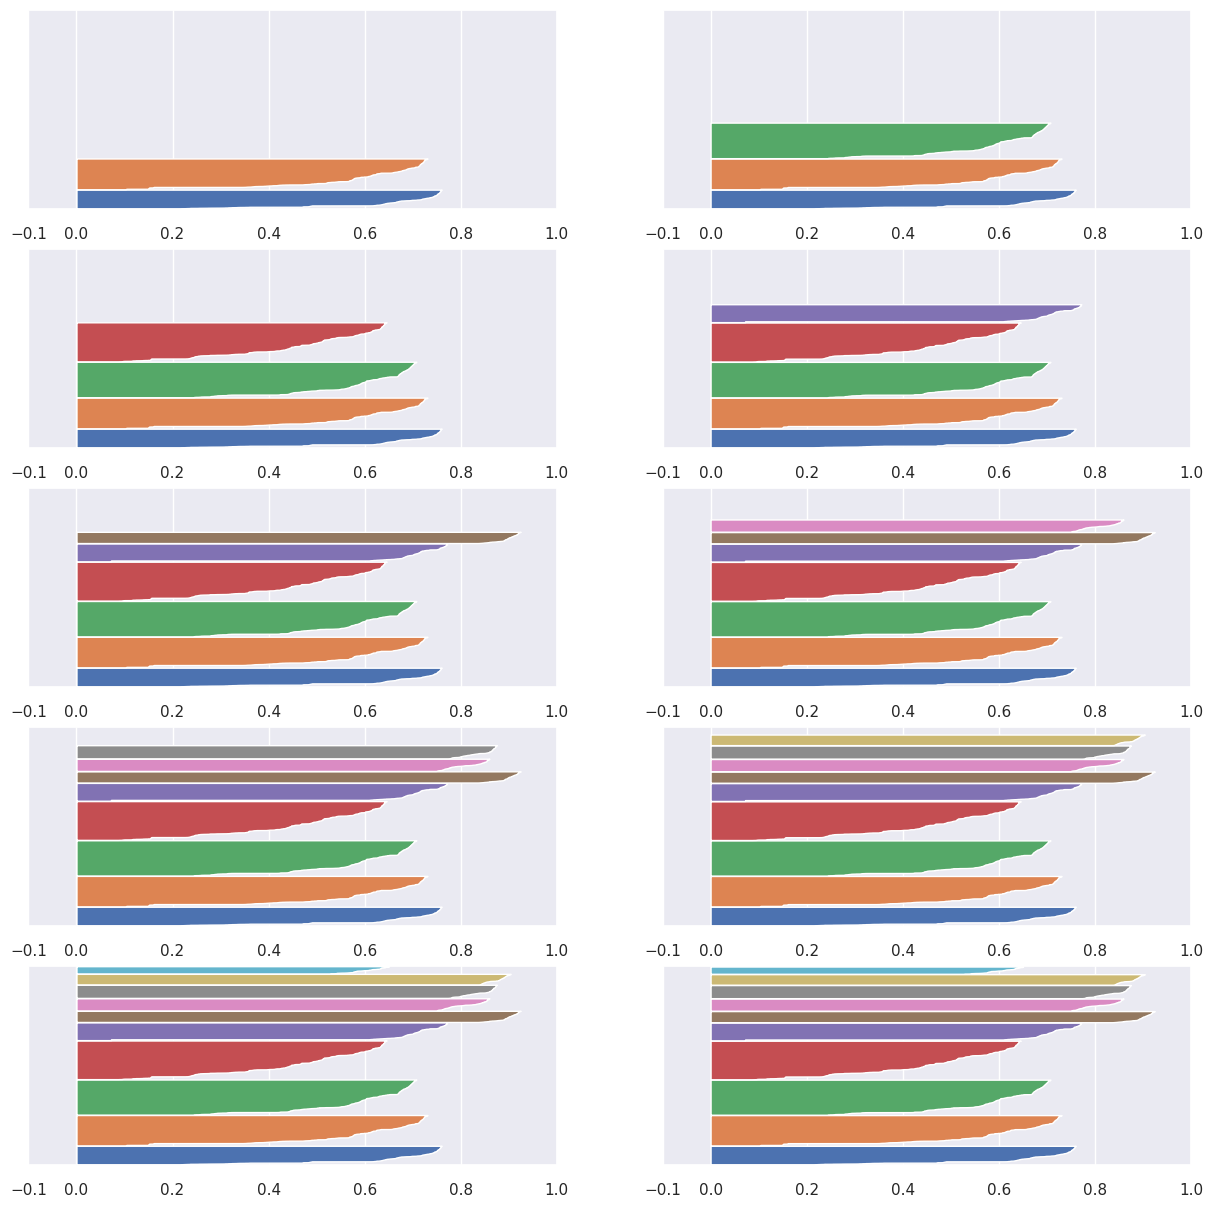

In [136]:
clusters=[2,3,4,5,6,7,8,9,10,11]

fig, ax = plt.subplots( 5, 2 )
fig.set_size_inches( 15, 15 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( df99 ) + ( k+1 )*10] )
    samples_silhouette_values = m.silhouette_samples( df99, labels1 )

    
    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels1 == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10

    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 7.4.2 GMM

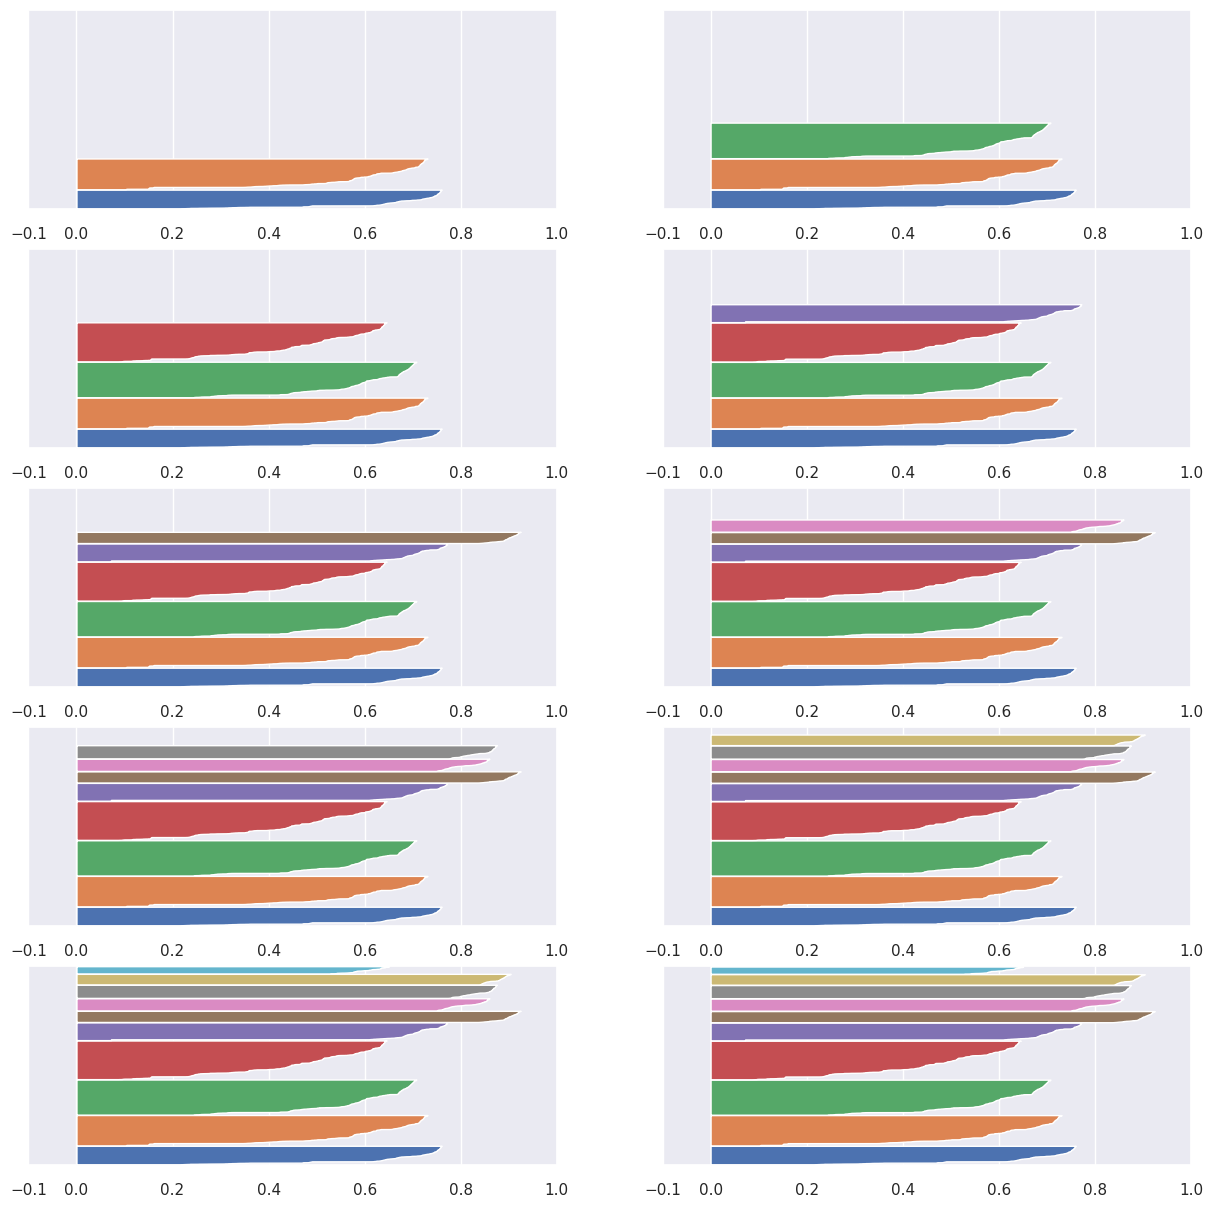

In [192]:
clusters=[2,3,4,5,6,7,8,9,10,11]

fig, ax = plt.subplots( 5, 2 )
fig.set_size_inches( 15, 15 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( df99 ) + ( k+1 )*10] )
    samples_silhouette_values = m.silhouette_samples( df99, labels4 )

    
    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels4 == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10

    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 7.4.3 Hierarchical clustering

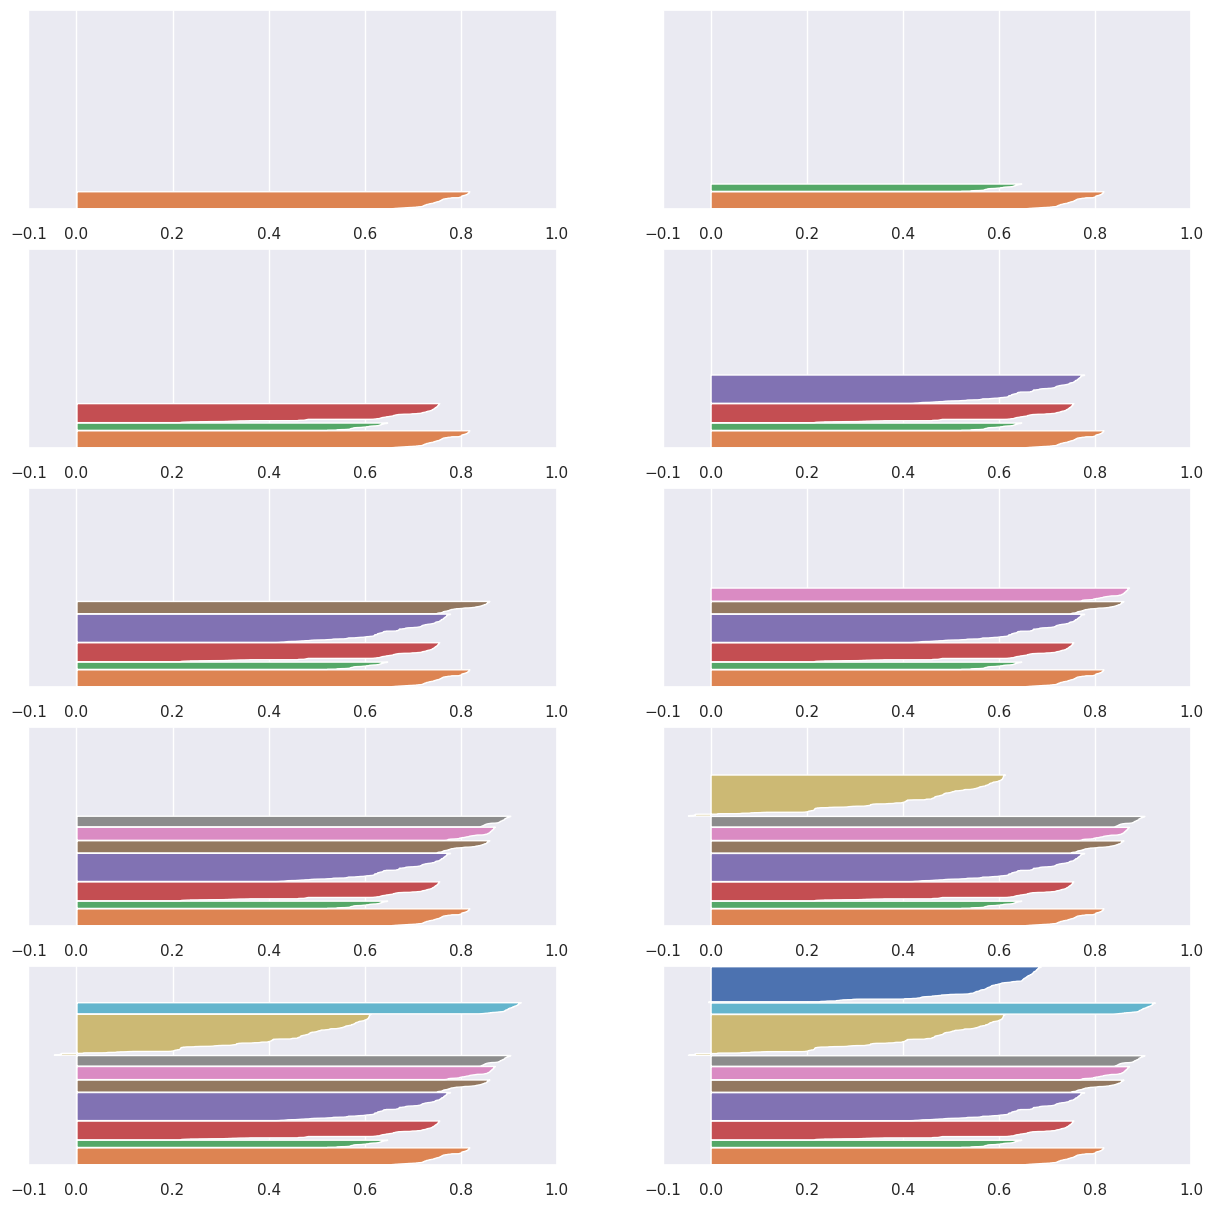

In [191]:
clusters=[2,3,4,5,6,7,8,9,10,11]

fig, ax = plt.subplots( 5, 2 )
fig.set_size_inches( 15, 15 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( df99 ) + ( k+1 )*10] )
    samples_silhouette_values = m.silhouette_samples( df99, labels5 )

    
    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels5 == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10

    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0 Cluster analysis

In [198]:
df9=df7.copy()

## 8.1 Visualization inspection

## 8.2 2d plot

In [124]:
# sns.pairplot(df_viz, hue='cluster');

## 8.3 UMAP


In [125]:
# # embedding
# df99['cluster'] = labels

# # plot UMAP
# sns.scatterplot(x='embedding_x', y='embedding_y', 
#                  hue='cluster', 
#                  palette=sns.color_palette('hls', n_colors=len(df99['cluster'].unique())),
#                  data=df99);

## 8.4 Cluster profile

In [199]:
df91 = df9.copy()
df91['cluster'] = labels5

# Percentual of customers
df_cluster = df91[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())
df_cluster['perc_customer']=df_cluster['perc_customer'].map('{:,.2f} %'.format)

# Avg Gross revenue
df_avg_gross_revenue = df91[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')
df_cluster=df_cluster.rename(columns={'gross_revenue':'avg_gross_revenue'})

# Gross revenue percentual
df_gross_perc = df91[['cluster', 'gross_revenue']].groupby('cluster').sum().reset_index()
df_cluster['gross_perc'] = 100*(df_cluster['avg_gross_revenue'] / df_cluster['avg_gross_revenue'].sum())
df_cluster['gross_perc']=df_cluster['gross_perc'].map('{:,.2f} %'.format)

# Avg recency days
df_avg_recency_days = df91[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')
df_cluster['recency_days']=df_cluster['recency_days'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'recency_days':'avg_recency_days'})

# Avg invoice_no
df_invoice_no = df91[['total_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')
df_cluster['total_invoices']=df_cluster['total_invoices'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'total_invoices':'avg_invoices'})

# Avg items qtt
df_items = df91[['items_qtt', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_items, how='inner', on='cluster')
df_cluster['items_qtt']=df_cluster['items_qtt'].astype(int)
df_cluster=df_cluster.rename(columns={'items_qtt':'avg_items'})

# Avg products qtt
df_products = df91[['products_qtt', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_products, how='inner', on='cluster')
df_cluster['products_qtt']=df_cluster['products_qtt'].astype(int)
df_cluster=df_cluster.rename(columns={'products_qtt':'avg_products'})

# Avg returns
df_returns = df91[['returns_qtt', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')
df_cluster['returns_qtt']=df_cluster['returns_qtt'].astype(int)
df_cluster=df_cluster.rename(columns={'returns_qtt':'avg_returns'})


df_cluster=df_cluster.sort_values(['avg_gross_revenue'],ascending=False).reset_index(drop=True)

df_cluster['avg_gross_revenue']=df_cluster['avg_gross_revenue'].map('$ {:,.2f}'.format)

df_cluster=df_cluster.rename(columns={'customer_id':'customers'})

df_cluster.loc[0:0,'cluster'] = 0
df_cluster.loc[1:1,'cluster'] = 1
df_cluster.loc[2:2,'cluster'] = 2

rows=df_cluster.shape[0:1]
rows=int(rows[0])

if rows>3:
        df_cluster.loc[3:3,'cluster'] = 3
        df_cluster.loc[4:4,'cluster'] = 4
        df_cluster.loc[5:5,'cluster'] = 5
        df_cluster.loc[6:6,'cluster'] = 6
        df_cluster.loc[7:7,'cluster'] = 7
        df_cluster.loc[8:8,'cluster'] = 8
        df_cluster.loc[9:9,'cluster'] = 9
        df_cluster.loc[10:10,'cluster'] = 10
else:
    None

df_cluster

,cluster,customer_id,perc_customer,avg_gross_revenue,gross_perc,avg_recency_days,avg_invoices
0,0,550,9.66 %,"$ 10,280.14",60.93 %,44.65,13.39
1,1,383,6.73 %,"$ 2,558.74",15.17 %,40.64,6.62
2,2,819,14.38 %,"$ 1,749.00",10.37 %,67.88,4.01
3,3,1194,20.97 %,"$ 1,007.03",5.97 %,104.02,2.35
4,4,1050,18.44 %,$ 457.00,2.71 %,132.66,1.80
5,5,309,5.43 %,$ 269.31,1.60 %,181.83,1.27
6,6,326,5.73 %,$ 265.58,1.57 %,155.44,1.08
7,7,356,6.25 %,$ 201.17,1.19 %,179.47,1.15
8,8,494,8.68 %,$ 69.85,0.41 %,193.41,1.05
9,9,213,3.74 %,$ 13.15,0.08 %,188.17,1.00


# <font color='red'> 9.0 Deploy To Production </font>